### Importing libs

In [429]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from heuristics.closest_neighbor import closest_neighbor
from typing import List, Dict, Set, Any, Tuple
from itertools import product
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#### Import data set

In [430]:
try:
    data_set = get_data_json("../../data/Treviso/13Treviso30.json")
    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 2
    Q = vehicle_capacity
    q = demands
    c = distance_matrix
except Exception as e:
    raise e

2024-09-24 09:34:24.351 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


#### Visualize the distance matrix as a DataFrame

In [431]:
df = pd.DataFrame(c)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,1439,874,581,2173,3067,4249,2638,5773,1930,2764,2472,5095,2160,1437,7532,7281,979
1,1366,0,1513,752,1366,2588,3770,2385,5293,2046,1957,2588,5211,2276,1334,7648,7397,1094
2,367,1617,0,760,2351,3246,4427,2816,5951,2108,2942,2650,5273,2338,1616,7710,7459,1157
3,616,858,763,0,1592,2486,3668,2057,5192,1349,2183,1891,4514,1579,1326,6951,6700,398
4,3386,2652,3533,2771,0,1222,2404,1748,3927,2116,1597,2658,5281,2346,3032,7292,7041,2192
5,3520,2736,3666,2905,1857,0,1667,1651,2865,2020,1500,1683,4274,2250,2295,6070,5819,2897
6,2741,1957,2887,2126,1395,2483,0,2239,3732,3307,1986,3849,6323,3537,1516,8119,7868,2469
7,2813,1709,2960,2198,2580,1209,2390,0,3914,1543,340,2085,4708,1774,2781,6943,6692,1619
8,5277,4493,5424,4662,3615,2523,2887,4174,0,4543,4023,4206,6441,4773,4052,8237,7986,5005
9,3378,2332,3525,2763,2836,1465,2646,1738,4170,0,1980,542,3165,829,3273,5602,5351,2184


#### Creating model instance

In [432]:
model = mip.Model(sense=mip.MINIMIZE, solver_name=mip.CBC)

#### Define binary

In [433]:
x: Dict[Tuple[int, int], mip.Var] = {
    (i, j): model.add_var(name=f"x_{i}_{j}", var_type=mip.BINARY) for (i, j) in A
}

#### Set the objective function to minimize total distance

In [434]:
model.objective = mip.minimize(
    mip.xsum(int(cost) * x[i, j] for (i, j), cost in A.items())
)

#### Set the m-TSP essential constraints

In [435]:
model += mip.xsum(x[i, i] for i in V) == 0

for j in V - {0}:
    model += mip.xsum(x[i, j] for i in V) == 1  # Inflow
    model += mip.xsum(x[j, i] for i in V) == 1  # Outflow

model += mip.xsum(x[0, j] for j in V - {0}) <= m  # Vehicle limit

model += (
    mip.xsum(x[0, j] for j in V - {0}) - mip.xsum(x[j, 0] for j in V - {0}) == 0
)  # All vehicles used must return to depot

#### Generate an initial solution using closest neighbor heuristics

In [436]:
def generate_initial_solution(
    stations: Set[int],
    demands: List[int],
    distance_matrix: np.matrix,
    vehicle_capacity: int,
    x: Dict[Tuple[int, int], mip.Var],
) -> List[Tuple[mip.Var, int]]:
    depot = 0
    customers = list(stations - {depot})
    demand_dict = dict(enumerate(demands))
    routes = closest_neighbor(
        depot, customers, demand_dict, distance_matrix, vehicle_capacity
    )

    initial_solution: List[Tuple[mip.Var, int]] = []
    for route in routes:
        for i, j in zip(route, route[1:]):
            initial_solution.append((x[i, j], 1))

    return initial_solution

In [437]:
initial_solution = generate_initial_solution(V, q, c, Q, x)

#### Implement separation procedure for subtour elimination

In [438]:
class LazySeparationProcedure(mip.ConstrsGenerator):
    def __init__(
        self,
        V: Set[int],
        A: Dict[Tuple[int, int], Any],
        q: List[int],
        Q: int,
        x: Dict[Tuple[int, int], mip.Var],
    ):
        self.V = V
        self.A = A
        self.x = x
        self.q = q
        self.Q = Q

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        vertices = self.V
        cut_pool = mip.CutPool()
        demands = self.q
        y = model.translate(self.x)

        qtot = sum(demands)
        demands[0] = qtot

        # First Separation (asymmetric graph G')
        G_prime = nx.DiGraph()
        G_prime.add_nodes_from(vertices)

        u = max(vertices) + 1
        v = max(vertices) + 2

        G_prime.add_nodes_from([u, v])

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for i, j in arcs_prime:
            G_prime.add_edge(i, j, capacity=y[i, j].x)

        for vertice, demand in dict(enumerate(demands)).items():
            if demand > 0:
                G_prime.add_edge(u, vertice, capacity=(demand/self.Q))
            else:
                G_prime.add_edge(v, vertice, capacity=((-demand)/self.Q))

        flow_value, _ = nx.maximum_flow(G_prime, u, v)

        if flow_value < 1:
            _, (S, _) = nx.minimum_cut(G_prime, u, v)
            S = S - {0}

            tour = [
                (y[i, j], y[i, j].x)
                for i, j in product(vertices, vertices)
                if i != j
                and y[i, j]
                and i in S
                and j in S
                and i in vertices
                and j in vertices
            ]

            sum_demands = np.abs(sum(demands[i] for i in S if i in vertices))
            min_vehicles = np.ceil(sum_demands / self.Q)


            if sum(value for _, value in tour) >= (len(S) - max(1, min_vehicles)):
                cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - max(
                    1, min_vehicles
                )
                cut_pool.add(cut)

        # Second Separation (asymmetric graph G'')
        G_double_prime = nx.DiGraph()
        G_double_prime.add_nodes_from(vertices)

        G_double_prime.add_nodes_from([u, v])

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for i, j in arcs_prime:
            G_double_prime.add_edge(i, j, capacity=y[i, j].x)

        for i in vertices:
            if demands[i] < 0: 
                G_double_prime.add_edge(u, i, capacity=(-demands[i]/vehicle_capacity))
            else:
                G_double_prime.add_edge(i, v, capacity=(demands[i]/vehicle_capacity))


        flow_value, _ = nx.maximum_flow(G_double_prime, u, v)

        if flow_value < 1:
            _, (N, _) = nx.minimum_cut(G_double_prime, u, v)

            N = N - {0}

            N_tour = [
                (y[i, j], y[i, j].x)
                for i, j in product(vertices, vertices)
                if i != j
                and y[i, j]
                and i in N
                and j in N
                and i in vertices
                and j in vertices
            ]

            sum_demands = np.abs(sum(demands[i] for i in N if i in vertices))
            min_vehicles = np.ceil(sum_demands / self.Q)

            if sum(value for _, value in N_tour) >= (len(N) - max(1, min_vehicles)):
                cut = mip.xsum(1 * var for var, _ in N_tour) <= len(N) - max(
                    1, min_vehicles
                )
                cut_pool.add(cut)

        for cut in cut_pool.cuts:
            model += cut

        # Restore depot demand
        demands[0] = 0

In [439]:
model.start = initial_solution
model.lazy_constrs_generator = LazySeparationProcedure(V, A, q, Q, x)
model.optimize(max_seconds=300)

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 36 (-1) rows, 306 (-18) columns and 629 (-52) elements
Clp1000I sum of infeasibilities 7.98906e-07 - average 2.21918e-08, 302 fixed columns
Coin0506I Presolve 0 (-36) rows, 0 (-306) columns and 0 (-629) elements
Clp0000I Optimal - objective value 22435
Clp0000I Optimal - objective value 22435
Coin0511I After Postsolve, objective 22435, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 22435 Dual inf 19040 (17)
Clp0014I Perturbing problem by 0.001% of 1.0032577 - largest nonzero change 1.9188505e-05 ( 0.00095942526%) - largest zero change 1.2489458e-05
Clp0000I Optimal - objective value 22435
Clp0000I Optimal - objective value 22435
Clp0000I Optimal - objective value 22435
Coin0511I After Postsolve, objective 22435, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 22435 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Cbc004

<OptimizationStatus.OPTIMAL: 0>

In [440]:
if model.num_solutions:
    selected_edges = [
        (origin, destination)
        for origin in V
        for destination in V
        if 0.5 <= x[origin, destination].x and x[origin, destination].x <= 1
    ]

    for origin, destination in selected_edges:
        edge_variable = model.var_by_name(f"x_{origin}_{destination}")
        edge_value = x[origin, destination].x
        print(f"{edge_variable} = {edge_value}")

x_0_2 = 1.0
x_1_3 = 1.0
x_2_0 = 1.0
x_3_17 = 1.0
x_4_5 = 1.0
x_5_8 = 1.0
x_6_14 = 1.0
x_7_10 = 1.0
x_8_6 = 1.0
x_9_11 = 1.0
x_10_7 = 1.0
x_11_12 = 1.0
x_12_13 = 1.0
x_13_9 = 1.0
x_14_4 = 1.0
x_15_16 = 1.0
x_16_15 = 1.0
x_17_1 = 1.0


In [441]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -2
Station 2: -4
Station 3: 1
Station 4: -3
Station 5: -1
Station 6: 2
Station 7: -2
Station 8: -2
Station 9: 1
Station 10: 1
Station 11: 2
Station 12: -4
Station 13: 3
Station 14: -2
Station 15: 1
Station 16: -3
Station 17: -3


In [442]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

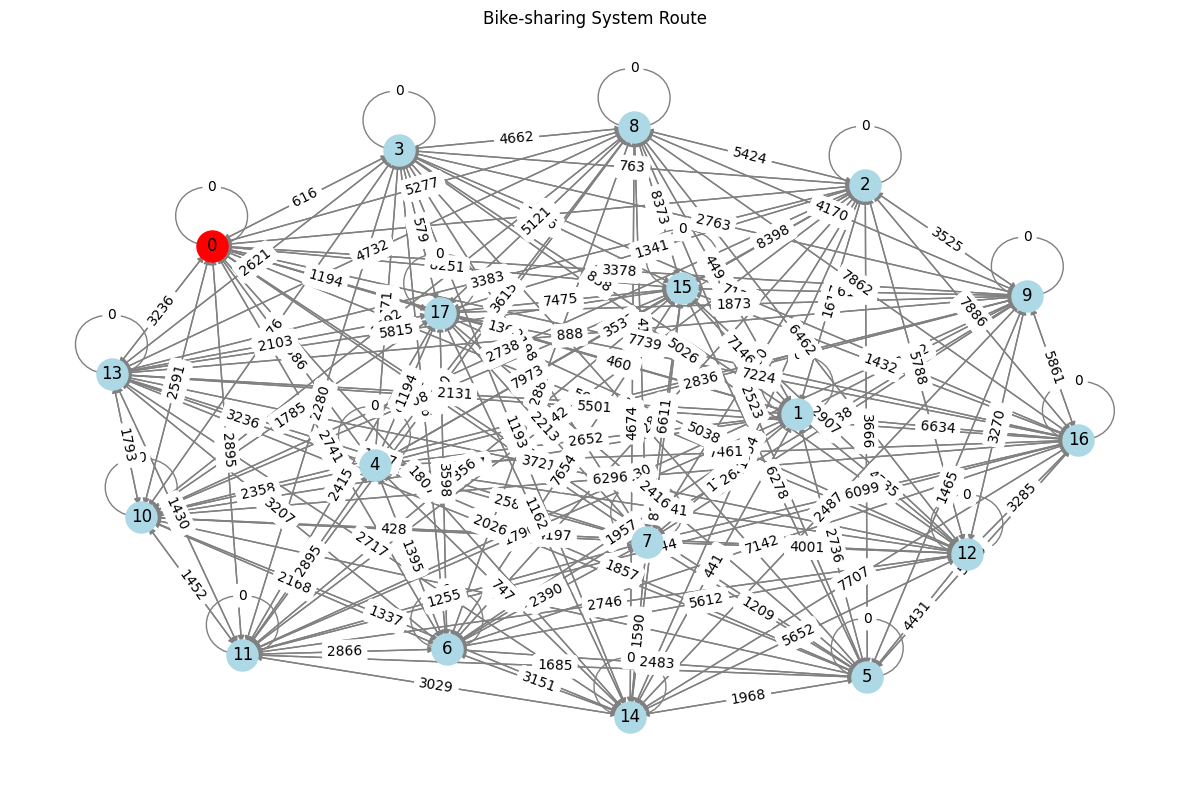

In [443]:
plot_route(V, A)

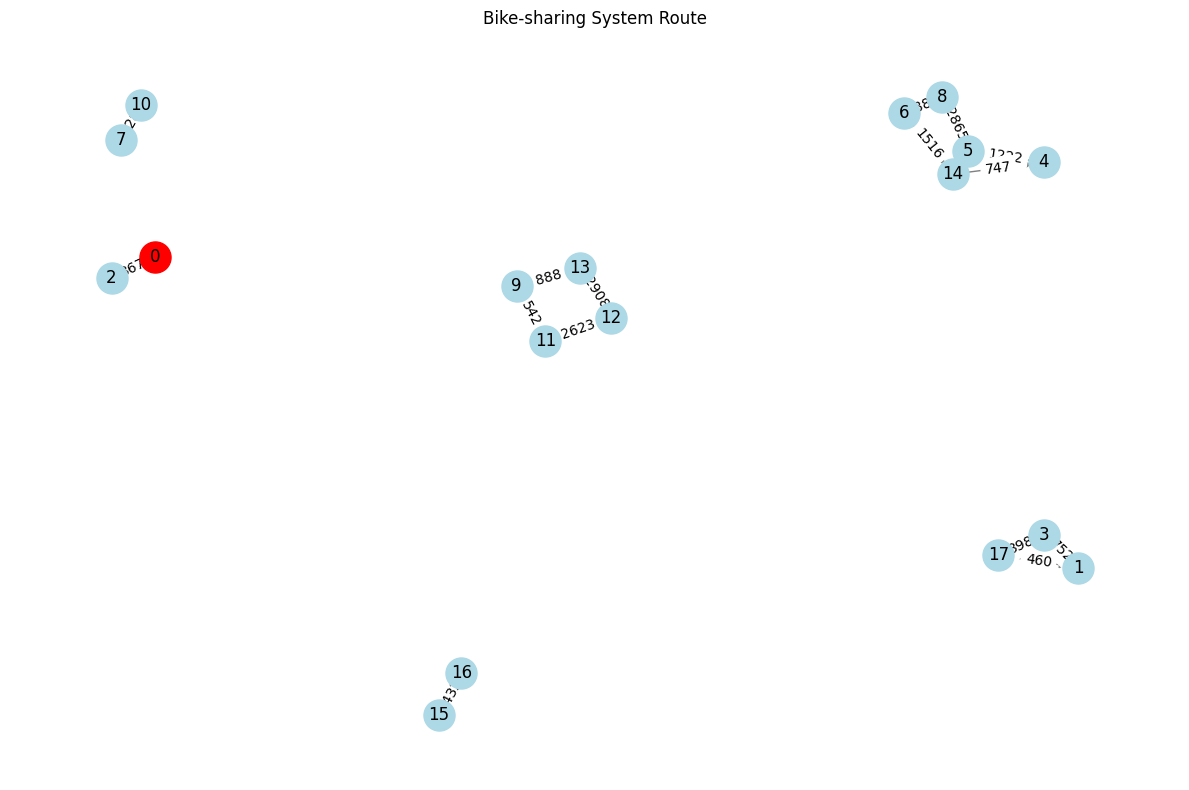

In [444]:
plot_route(V, selected_edges)